In [1]:
import sys
import os
sys.path.append('..')
from adjoint_esn.dynamical_systems import Lorenz63
import adjoint_esn.solve_ode as solve_ode
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN

In [2]:
# run lorenz system
my_lorenz63 = Lorenz63(beta=8/3, rho=28, sigma=10, t_lyap=0.906**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 53*my_lorenz63.t_lyap
t_val_len = 5*my_lorenz63.t_lyap
t_sim_len = t_transient_len+t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((my_lorenz63.N_dim)) 
U_sim = solve_ode.integrate(my_lorenz63, u0, t_sim, integrator='forward_euler')

# upsample
U = U_sim[::upsample,:]
t = t_sim[::upsample]

# cut the transient    
N_transient = int(np.round(t_transient_len/dt))
U = U[N_transient:,:]

# separate into washout, train, val
N_washout = int(np.round(t_washout_len/dt))
N_train = int(np.round(t_train_len/dt))
N_val = int(np.round(t_val_len/dt))

U_washout = U[0:N_washout,:]

U_train = U[N_washout:N_washout+N_train-1,:]
Y_train = U[N_washout+1:N_washout+N_train,:]
t_train = t[N_washout+1:N_washout+N_train]

U_val = U[N_washout+N_train:N_washout+N_train+N_val-1,:]
Y_val = U[N_washout+N_train+1:N_washout+N_train+N_val,:]
t_val = t[N_washout+N_train+1:N_washout+N_train+N_val]

Running solver.


In [3]:
U_data = U[:N_washout+N_train]
U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

In [4]:
input_bias = np.array([np.mean(np.abs((U_data-scale[0])/scale[1]))])
my_ESN = ESN(reservoir_size = 200, dimension = my_lorenz63.N_dim, reservoir_connectivity = 3, 
                input_scaling = 0.3, spectral_radius = 0.64,
                leak_factor = 1.0, input_bias = input_bias)

Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [5]:
my_ESN.train(U_washout, U_train, Y_train, tikhonov = 1e-12, scale = scale)

In [6]:
X_pred, Y_pred = my_ESN.closed_loop_with_washout(U_washout, N_t = N_train+N_val-2, scale = scale)
Y_pred_train = Y_pred[1:N_train,:]
Y_pred_val = Y_pred[N_train-1:-1,:]

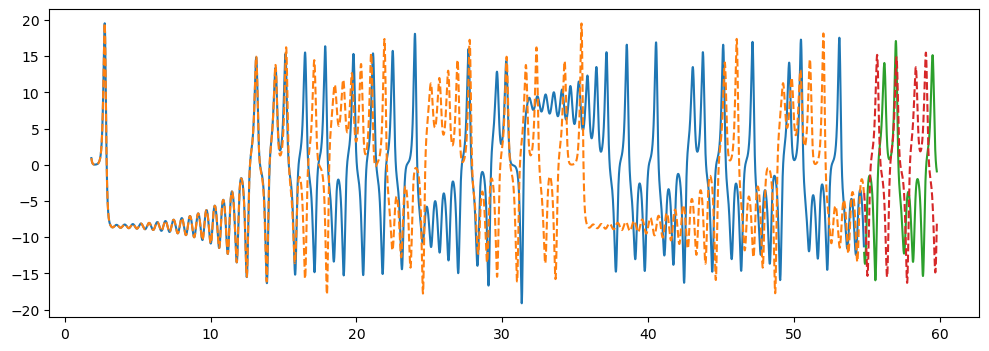

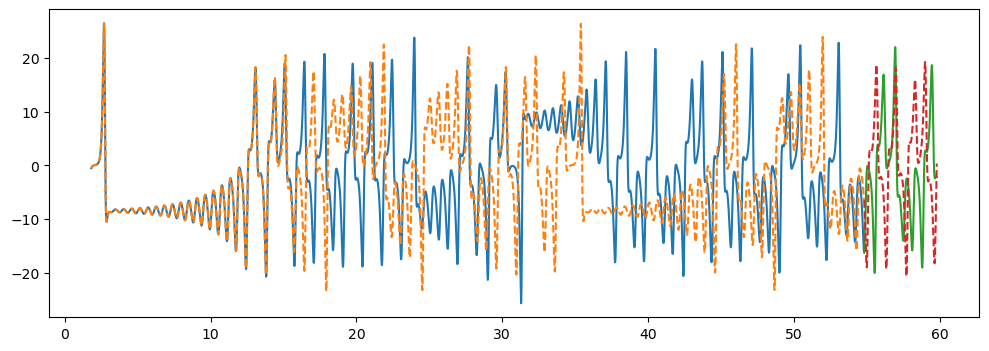

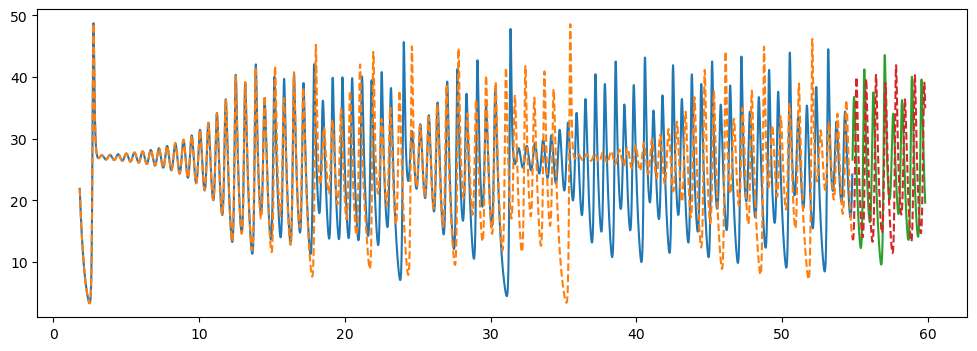

In [7]:
for j in range(my_lorenz63.N_dim):
    plt.figure(figsize=(12,4))
    plt.plot(t_train/my_lorenz63.t_lyap, Y_train[:,j])
    plt.plot(t_train/my_lorenz63.t_lyap, Y_pred_train[:,j],'--')
    plt.plot(t_val/my_lorenz63.t_lyap, Y_val[:,j])
    plt.plot(t_val/my_lorenz63.t_lyap, Y_pred_val[:,j],'--')

In [8]:
from adjoint_esn.validation import validate

#range for hyperparameters (spectral radius and input scaling)
spec_in     = .1    
spec_end    = 1.   
in_scal_in  = np.log10(0.05)
in_scal_end = np.log10(5.)
#leak_in     = .8    
#leak_end    = 1.   
grid_range = [[spec_in, spec_end], [in_scal_in, in_scal_end]]

# In case we want to start from a grid_search, 
# the first n_grid_x*n_grid_y points are from grid search
n_grid_x = 6 
n_grid_y = 6
#n_grid_z = 2

param_names = ['spectral_radius', 'input_scaling']
param_scales = ['uniform', 'log10']
n_grid = [n_grid_x, n_grid_y]

ESN_dict = {'reservoir_size': 200, 
            'dimension' : 3, 
            'reservoir_connectivity' : 3, 
            'input_bias' : input_bias}
min_dict = validate(n_grid, grid_range, param_names, param_scales, 
    n_bo = 4, n_initial = 0, n_ensemble = 3, ESN_dict = ESN_dict, U_washout = U_washout, 
    U = U_train, Y = Y_train, data_scale = scale, n_folds = 25, N_init_steps = 50, N_fwd_steps = 50, N_washout_steps = 50, N_val_steps = 500)

c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.62003e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.13352e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.38259e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.01216e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\egeoz\anaconda3

In [11]:
min_dict # okay why are all realisations converging to the same 

{'params': [[0.64, 0.3154786722400966],
  [0.64, 0.3154786722400966],
  [0.64, 0.3154786722400966]],
 'tikh': [1e-12, 1e-12, 1e-12],
 'f': array([-6.37348594, -6.01175965, -6.2823829 ])}